In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import random
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mask = nib.load('/content/drive/MyDrive/1 Sagol Project/Mask/Tian_Subcortex_S3_3T.nii').get_fdata()

striatum = list(range(11, 19)) + list(range(22,24)) + list(range(36, 44)) + list(range(47,49))


bool_mask = np.isin(mask, striatum)

mask[~bool_mask] = 0
mask[bool_mask] = 1

r_mask, l_mask = np.copy(mask), np.copy(mask)
r_mask[45:,:,:] = 0;
r_mask = r_mask.flatten()
l_mask[:45,:,:] = 0;
l_mask = l_mask.flatten()

mask = mask.flatten()
mask = np.stack([mask for i in range(0,50)])
mask = np.transpose(mask)

In [ ]:
fmri_folder_path = '/content/drive/MyDrive/1 Sagol Project/Features/'
pet_folder_path = '/content/drive/MyDrive/1 Sagol Project/PET/'

In [ ]:
mm = MinMaxScaler()

In [ ]:
Y = []

for file in os.listdir(pet_folder_path):
  file_path = os.path.join(pet_folder_path, file)
  temp_pet = nib.load(file_path).get_fdata()
  temp_pet = temp_pet.flatten()[mask[:,0] != 0]
  temp_pet = mm.fit_transform(temp_pet.reshape(-1,1))
  Y.append(temp_pet)


In [ ]:
X = []

for file in os.listdir(fmri_folder_path):
  file_path = os.path.join(fmri_folder_path, file)
  temp_fmri = nib.load(file_path).get_fdata()
  temp_fmri = temp_fmri.reshape(-1, temp_fmri.shape[-1])
  temp_fmri = temp_fmri[~np.all(mask == 0, axis=1)]
  temp_fmri = mm.fit_transform(temp_fmri)
  X.append(temp_fmri)


In [ ]:
k = 0

for i in range(26):
  if i not in (4,5,11,15,17,20,22,24):
    Y[k] = Y[i]
    X[k] = X[i]
    k += 1

Y = Y[:18]
X = X[:18]

In [ ]:
# 0 - right, 1 - left, 18 Subjects
clinical_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

In [ ]:
pred_list = [0 for i in range(18)]
acc_arr = np.zeros(1000)
acc_arr[0] = 13/18

In [ ]:
# permutation test

for test_num in range(1,1000):

  # random shuffling of PET images and clinical labels

  zipped = list(zip(Y, clinical_labels))
  random.shuffle(zipped)
  Y, clinical_labels = zip(*zipped)
  Y, clinical_labels = list(Y), list(clinical_labels)

  for i in range(18):

    features = np.concatenate(X[:17])
    target = np.concatenate(Y[:17])
    xgb_model = xgb.XGBRegressor(max_depth = 3).fit(features, target)
    pred = xgb_model.predict(X[17])

    pred_copy = np.copy(pred)
    unmasked_pet = np.copy(mask[:,0])

    for k in range(len(mask[:,0])):
      if unmasked_pet[k] == 1:
        unmasked_pet[k] = pred_copy[0];
        pred_copy = pred_copy[1:];

    pred = unmasked_pet

    pred_SUVR_r, pred_SUVR_l = pred[r_mask!= 0].mean(), pred[l_mask!= 0].mean()
    pred_label = (pred_SUVR_r > pred_SUVR_l).astype(int)
    pred_list[17-i] = pred_label

    X.insert(0, X.pop(17))
    Y.insert(0, Y.pop(17))

  acc_arr[test_num] = sum([pred_list[i] == clinical_labels[i] for i in range(18)]) / 18

  print(test_num)
  print(acc_arr[test_num])


1
0.5555555555555556
2
0.5
3
0.6666666666666666
4
0.5
5
0.3888888888888889
6
0.5555555555555556
7
0.2777777777777778
8
0.4444444444444444
9
0.5555555555555556
10
0.4444444444444444
11
0.5555555555555556
12
0.4444444444444444
13
0.5
14
0.5
15
0.4444444444444444
16
0.6111111111111112
17
0.3888888888888889
18
0.5555555555555556
19
0.5555555555555556
20
0.6666666666666666
21
0.4444444444444444
22
0.6666666666666666
23
0.5
24
0.5
25
0.2777777777777778
26
0.5
27
0.5555555555555556
28
0.4444444444444444
29
0.6111111111111112
30
0.4444444444444444
31
0.7222222222222222
32
0.5555555555555556
33
0.5555555555555556
34
0.5
35
0.5555555555555556
36
0.3333333333333333
37
0.4444444444444444
38
0.5
39
0.4444444444444444
40
0.5
41
0.5
42
0.3888888888888889
43
0.6111111111111112
44
0.5555555555555556
45
0.6666666666666666
46
0.6666666666666666
47
0.3333333333333333
48
0.3333333333333333
49
0.4444444444444444
50
0.5
51
0.4444444444444444
52
0.4444444444444444
53
0.3888888888888889
54
0.6111111111111112
5

In [ ]:
p_value = np.sum(acc_arr >= 13/18)/1000
p_value

0.041

In [ ]:
counts = np.unique(acc_arr, return_counts = True)
counts

(array([0.16666667, 0.22222222, 0.27777778, 0.33333333, 0.38888889,
        0.44444444, 0.5       , 0.55555556, 0.61111111, 0.66666667,
        0.72222222, 0.77777778, 0.83333333]),
 array([  2,   5,  28,  69, 126, 197, 196, 163, 108,  65,  32,   5,   4]))

Text(0, 0.5, 'Number of Tests')

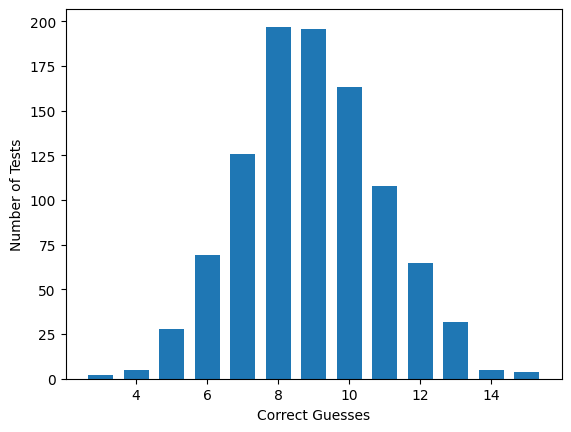

In [ ]:
# generate null hypothesis distribution for classification accuracy

fig, ax = plt.subplots()
ax.bar(counts[0]*18, counts[1], width=0.7)
ax.set_xlabel('Correct Guesses')
ax.set_ylabel('Number of Tests')